# Utilização da `BibMon` na detecção de eventos indesejados presentes no `3W Dataset`:

O presente notebook surgiu no `HACKTHON` Petrobras 2024' e demonstra como utilizar o software BibMon para detectar de eventos indesejáveis através de sensores marítimos em poços de petróleo.

> Isso é `EnergIA`! :)

Integrantes:

- Laura Magalhães
- Igor Infingardi
- Juliana Hansen
- Helena Lannes


# Importação e leitura da base de dados

Primeiramente, é necessário importar algumas bibliotecas e funções que serão usadas ao longo da análise:

Dica: Se você está usando o VSCode, só rodar um pip install para as bibliotecas! :)

In [1]:
import sys
import os
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import missingno

sys.path.append('3W')
sys.path.append('BibMon')

A importação dos arquivos será feita, por enquanto, diretamente da pasta do dataset fornecido pelo 3W.

`Aqui será necessário atualizar o PATH de acordo com a localidade do arquivo dataset no seu computador`

Para leitura, utilizaremos a função load_data data abaixo, que lê todos os arquivos dessa pasta, seja em csv ou parquet!

In [2]:
def load_data_from_file_name(event, fileName):
    PATH = os.path.join('..', '..', '..', '3W', 'dataset', str(event), str(fileName))     

    if os.path.exists(PATH):
        if os.path.isfile(PATH):
            file = PATH
        else:
            print(f"{PATH} não é um diretório.")
    else:
        print(f"O caminho {PATH} não existe.")
    
    dfs = {}
    
    if file.endswith('.csv'):
        # Tentar ler o arquivo CSV com a codificação padrão
        dfs[fileName[:-4]] = pd.read_csv(PATH, index_col=0, parse_dates=True).rename_axis(None)
    elif file.endswith('.parquet'):
        # Ler o arquivo Parquet
        dfs[fileName[:-8]] = pd.read_parquet(PATH)  # Remover o sufixo '.parquet'
    else:
        print(f"Formato de arquivo desconhecido para {file}.")

    return dfs

well = '00006'
dataFault = load_data_from_file_name(1, 'WELL-00006_20170731170930.parquet')

No dataset há diversos dados, a função getWellDataAndPlot separa todos os arquivos referentes aos poços (well - objeto de estudo) e lê o poço escolhido através do parâmetro well.

No banco de dados há muitas variáveis com valores vazios ou zerados, caso todos estejam nesse formato, a coluna será filtrada pois uma vez que se mantém sempre constante não agregará na nossa análise.

Algumas variáveis não são nulas o tempo inteiro, alternam entre NaN, 0 e vazio e optamos por filtrá-las manualmente por enquanto através da análise exploratório do banco de dados.

A função também plota subgráficos para cada variável, buscando justamente facilitar essa análise descrita acima.

In [3]:
def getWellDataAndPlot(data, color, well):
    archivesKeys = data.keys()

    filteredByWellData = pd.concat([data[key] for key in archivesKeys]) #Data filtrada para o poço
    
    filteredByWellData = filteredByWellData.apply(pd.to_numeric, errors='coerce')
    # Remover colunas que são todas NaN ou que contêm apenas zeros
    filteredByWellData = filteredByWellData.dropna(axis=1, how='all')  # Remove colunas que são todas NaN
    filteredByWellData = filteredByWellData.loc[:, (filteredByWellData != 0).any(axis=0)]  # Remove colunas que são todas 0
    # Filtra colunas onde todos os valores são iguais (remove colunas com todos os valores iguais)
    filteredByWellData = filteredByWellData.loc[:, filteredByWellData.nunique() > 1]

    tags = list(filteredByWellData.keys())
    # notWantedTags = ['ESTADO-M1', 'ESTADO-SDV-P', 'ESTADO-W1', 'P-PDG', 'QGL']
    # tags = [key for key in tags if key not in notWantedTags]

    fig, ax = plt.subplots(len(tags), 1, figsize=(18, 10),sharex=True)
    fig.suptitle(f"Poço {well}", fontsize=16)
    
    for i, tag in enumerate(tags):
        tagData = filteredByWellData[tag].values
        # print(tagData)
        ax[i].plot(tagData, c=color, linewidth=0.8)
        ax[i].set_ylabel(tag, rotation=0, fontsize=14)
        ax[i].set_yticks([])
    
        # Limpar bordas desnecessárias
        ax[i].spines["top"].set_visible(False)
        ax[i].spines["right"].set_visible(False)
        ax[i].spines["left"].set_visible(False)
    
        if i < len(tags)-1:  # Oculta os eixos X de todos, exceto o último gráfico
            ax[i].set_xticks([])
            ax[i].spines["bottom"].set_visible(False)
            ax[i].xaxis.set_ticks_position('none')
        else:
            # Rotaciona rótulos no último gráfico para melhor legibilidade
            for label in ax[i].get_xticklabels():
                label.set_rotation(45)
                label.set_ha('right')
    return filteredByWellData , tags
   


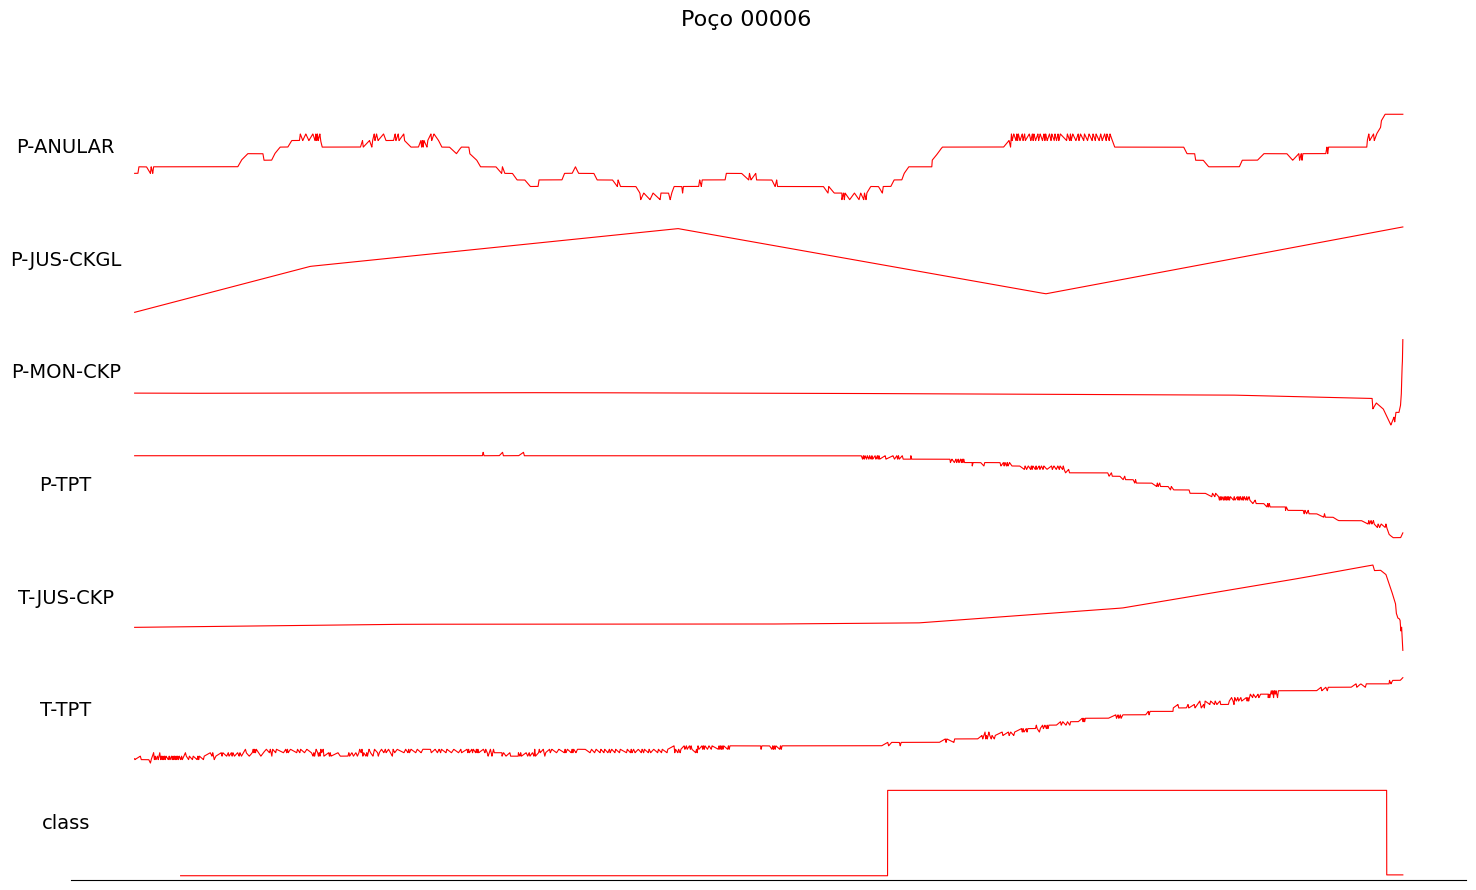

In [4]:
dataFault, tags1 = getWellDataAndPlot(dataFault, 'r', well)   

Acima em preto está o comportamento normal de operação e em vermelho está a operação com falha.
A variável class é a chave da determinação da falha, ela indica quando a variável entra no regime transitório de operação (pós-evento não esperado). quando ela está maior que 100, e quando está permanente pós falta, com class mais baixa mas diferente de 0. Em sua operação normal essa variável é 0.

Abaixo há a ordenação das datas. O print está sendo utilizado para verificarmos como essa data está.

In [5]:
dataFault.index = pd.to_datetime(dataFault.index)
dataFault = dataFault.sort_index()

print(dataFault)

                       P-ANULAR  P-JUS-CKGL  P-MON-CKP       P-TPT  T-JUS-CKP  \
timestamp                                                                       
2017-07-31 17:09:30  17775070.0   1272539.0  2540837.0  18373560.0   78.85014   
2017-07-31 17:09:31  17775070.0   1272541.0  2540836.0  18373560.0   78.85015   
2017-07-31 17:09:32  17775070.0   1272542.0  2540835.0  18373560.0   78.85016   
2017-07-31 17:09:33  17775070.0   1272543.0  2540834.0  18373560.0   78.85016   
2017-07-31 17:09:34  17775070.0   1272545.0  2540834.0  18373560.0   78.85017   
...                         ...         ...        ...         ...        ...   
2017-08-01 20:44:56  17954620.0   1308528.0  3522329.0  17922060.0   77.92796   
2017-08-01 20:44:57  17954620.0   1308529.0  3534952.0  17922220.0   77.91788   
2017-08-01 20:44:58  17954620.0   1308530.0  3547575.0  17922380.0   77.90780   
2017-08-01 20:44:59  17954620.0   1308531.0  3560197.0  17922540.0   77.89771   
2017-08-01 20:45:00  1795462

Como descrevemos acima, a variável class será utilizada para determinar os regimes de operação do sistemas e detecção de evento anormal.
Assim, encontraremos o início desse evento (quando class > 100) e seu fim, novo estado permanente pós falta.

In [6]:
index_above_100 = dataFault[dataFault['class'] > 100].index[0]

fault_start = index_above_100
fault_end = dataFault.index[-1]  # Último valor de dataFault

# Mostra os resultados
print("Início da falha onde primeiro índice class é maior que 100:", fault_start)
print("Fim da falha:", fault_end)


Início da falha onde primeiro índice class é maior que 100: 2017-08-01 09:32:22
Fim da falha: 2017-08-01 20:45:00


In [7]:
fault_start_position = dataFault.index.get_loc(fault_start)

# Calcular o número de dados entre o início e end_validation
n_train = fault_start_position - 1  # +1 para incluir o índice de end_validation

# Calcular 70% dos dados até end_validation
end_train_position = int(0.7 * n_train)

# Definir o índice de end_validation um pouco antes do início da falta
end_validation_position = int(0.9 * fault_start_position)
end_validation = dataFault.index[end_validation_position]

# Definir os índices start_train, end_train, end_validation e end_test
start_train = dataFault.index[0]
end_train = dataFault.index[end_train_position]  # Agora baseado em 85% até end_validation
end_test = dataFault.index[-1]

# Exibir os resultados
print(f"Início do treino: {start_train}")
print(f"Fim do treino (85% até end_validation): {end_train}")
print(f"Fim da validação: {end_validation}")
print(f"Fim do teste: {end_test}")


Início do treino: 2017-07-31 17:09:30
Fim do treino (85% até end_validation): 2017-08-01 04:37:29
Fim da validação: 2017-08-01 07:54:04
Fim do teste: 2017-08-01 20:45:00


## Modelagem e detecção das faltas

Para utilizar a `BibMon`, dividiremos nossa base de dados em treinamento, validação e teste. O treinamento gerará nosso modelo e a validação avaliará o modelo e rearranjar o limite de confiança para evitar overfitting, que ocorre quando o modelo está considerando ruídos e outras características que não são sempre constantes e normais.
No teste podemos verificar se o modelo consegue prever a operação normal ou prever uma falta, caso ela aconteça nesse período.


A função utilizada `train_val_test_split` realiza o treinamento, validação e teste em uma data consecutiva e, portanto, utilizaremos os dados lidos dos arquivos de falta. Essa primeira etapa será realizada durante a operação normal.

In [8]:
import bibmon 

(X_train, X_validation, 
 X_test, Y_train, 
 Y_validation, Y_test) = bibmon.train_val_test_split(dataFault, 
                                                     start_train = start_train, #Início da base de dados
                                                     end_train = end_train, 
                                                     end_validation = end_validation, #Horas antes da falta
                                                     end_test = end_test, #Fim da base de dados 
                                                     tags_Y = 'P-TPT') #Essa variável será usada para análise da regressão do modelo


In [9]:
from sklearn.ensemble import RandomForestRegressor  
reg = RandomForestRegressor(n_jobs=-1, random_state=1)

model = bibmon.sklearnRegressor(reg) 

In [10]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

mtr = [r2_score, mean_absolute_error]

A função `complete_analysis` fornece uma análise completa da detecção da falta e ajuda na avaliação do modelo. 

Nos gráficos da esquerda há os dados de `SPE`, que são os erros quadrados da previsão, e nos gráficos a direita a `regressão da variável escolhida` acima, que estaria representando o modelo.

O índice `r2_score` próximo de 1 indica que a regressão foi excelente e que o modelo está descrevendo os dados perfeitamente, caso esse valor seja negativo, o modelo não está descrevendo corretamente os dados.


CPU times: total: 11.5 s
Wall time: 5.38 s


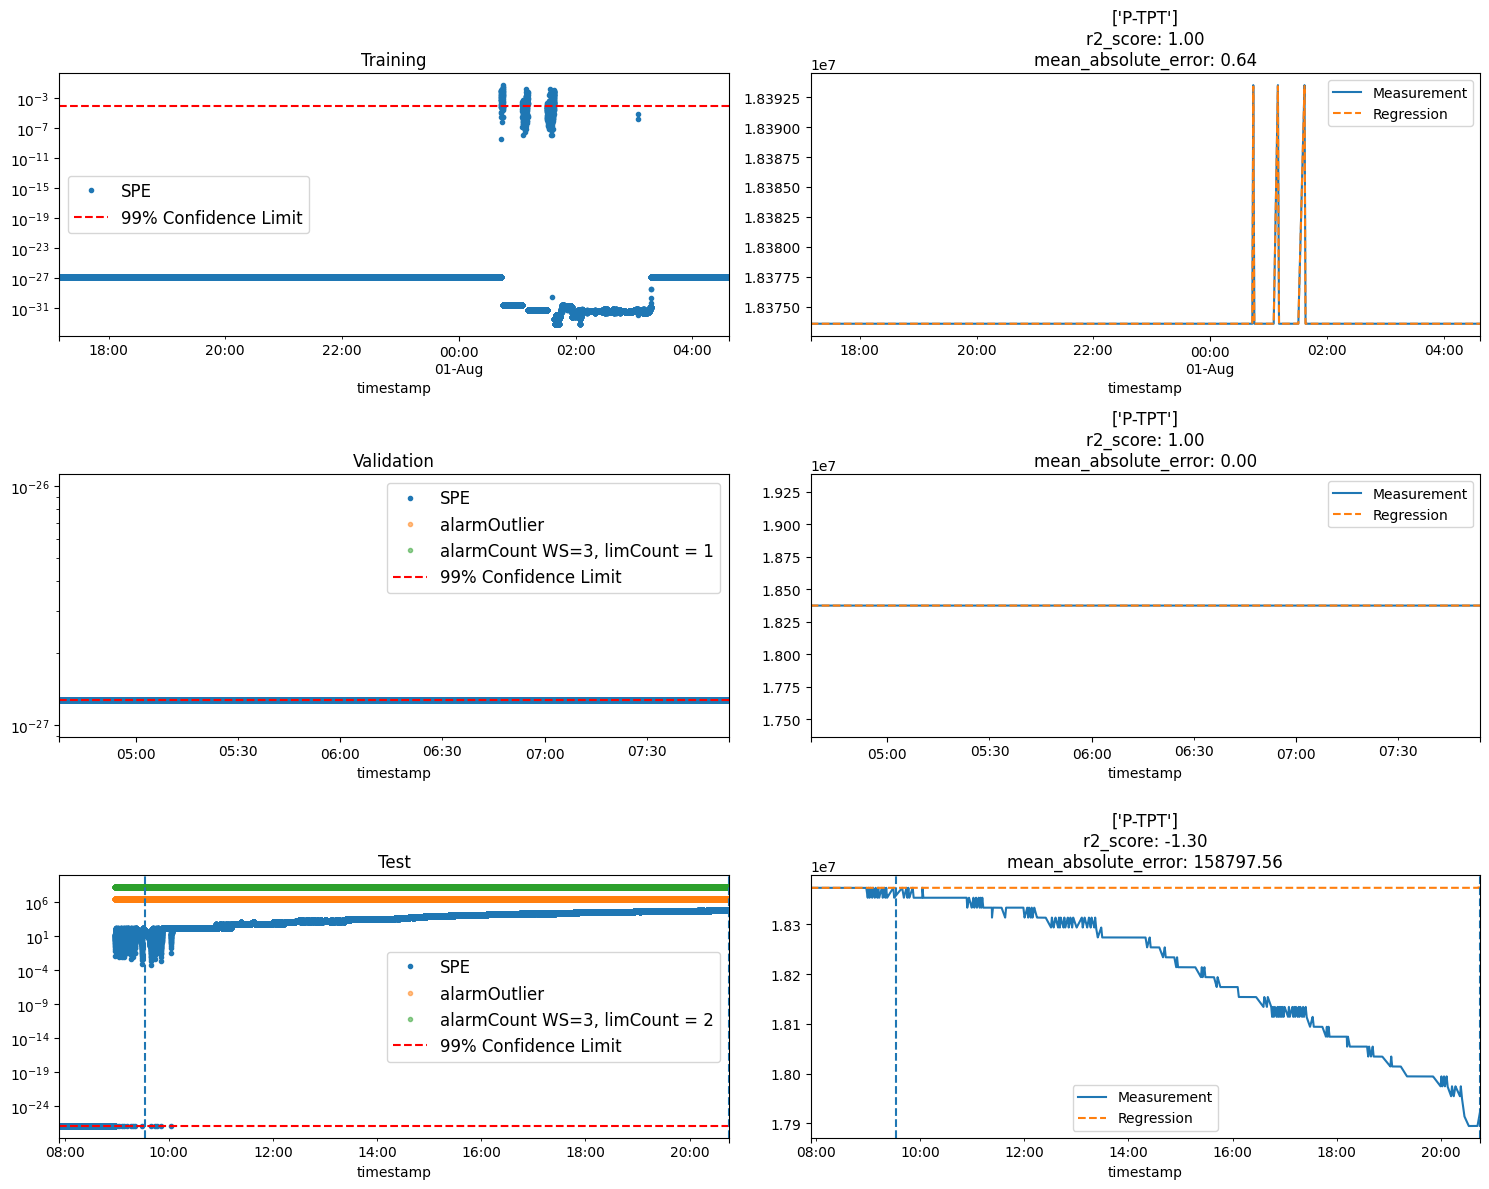

In [11]:
%%time
bibmon.complete_analysis(model, X_train, X_validation, X_test, 
                         Y_train, Y_validation, Y_test,                    
                         metrics = mtr, count_window_size = 3, count_limit = 2,
                         fault_start = fault_start,
                         fault_end = fault_end)                       

## Análises e conclusões da  primeira tentativa

Analisando os gráficos da esquerda conseguimos concluir que:
-  O modelo encontrado apresenta alguns alarmes falsos durante a fase de validação, mas que em casos de faltas ele consegue corretamente identificar falhas.

Analisando os gráficos de regressão a direita conseguimos ter outra análise:

- Devido aos índices negativos de r2_score na fase de validação conseguimos ver que o modelo está completamente overfitted e não consegue prever de forma satisfatória a variável escolhida em outro período de operação normal (caso da etapa de validação). 

`O que acreditamos que sejam os problemas`:

- Talvez a variável escolhida, sozinha, não descreva sozinha a operação do evento, talvez haja outra melhor para essa análise, ou um conjunto delas!
- O período de falta, infelizmente, é bem maior que o período que está sendo utilizado para validação.


`Propostas`:
- Encontrar quais variáveis seriam melhores para descrever o modelo e que serão utilizadas no parâmetro tags_Y.
- Ajudar o modelo a encontrar qual variável descreve melhor o sistema para os eventos utilizando as importãncias encontradas na primeira tentativa.
- Analisar todos os arquivos de dados e achar aqueles que são mais promissores para o treinamento com a BibMon, como falamos, nesse aqui o período de validação está muito pequeno, queríamos encontrar diversas operações de falta também, separamos alguns casos que seriam chaves:
    - Caso onde o evento gera longo transitório e depois entra em regime permanente diferente do regime de operação normal.
    - Caso onde o evento tem transitório curto e já entra em regime permanente diferente do regime de operação normal..
    - Caso onde há transitório e o permanente volta ao estado de operação normal, como se fosse uma instabilidade provisória que o próprio sistema consegue controlar de maneira satisfatória
- Concatenar o banco de dados de operação normal com os de falta para ter um período grande para treinamento.



## Segunda tentativa: facilitar a conclusão de qual variável é mais relevante para a análise do evento

Para isso será usada a função `plot_importances`

P-JUS-CKGL    0.535129
P-MON-CKP     0.311466
T-JUS-CKP     0.090972
T-TPT         0.057462
P-ANULAR      0.004971
Name: Importances, dtype: float64

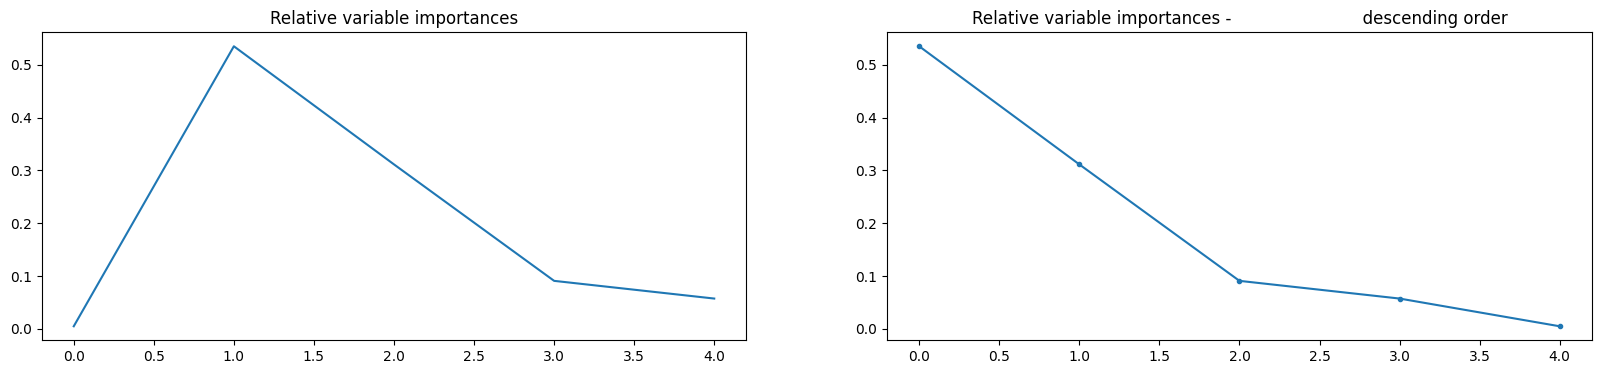

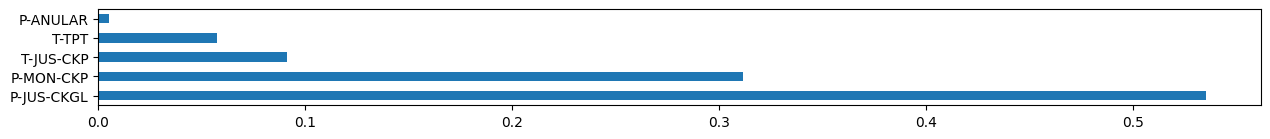

In [12]:
model.plot_importances(n=5)

A variável 'T-JUS-CKP' demonstrou ser bem mais relevante que as outras, assim, passaremos apenas ela como base para a análise:

É interessante analisar que provavelmente essa foi a mais relevante pois estávamos tentando prever a variável 'T-TPT', como ambas são de temperatura isso pode estar relacioando.
Caso mudássemos essa variável de tag_Y, provavelmente a mais relevante também alteraria.

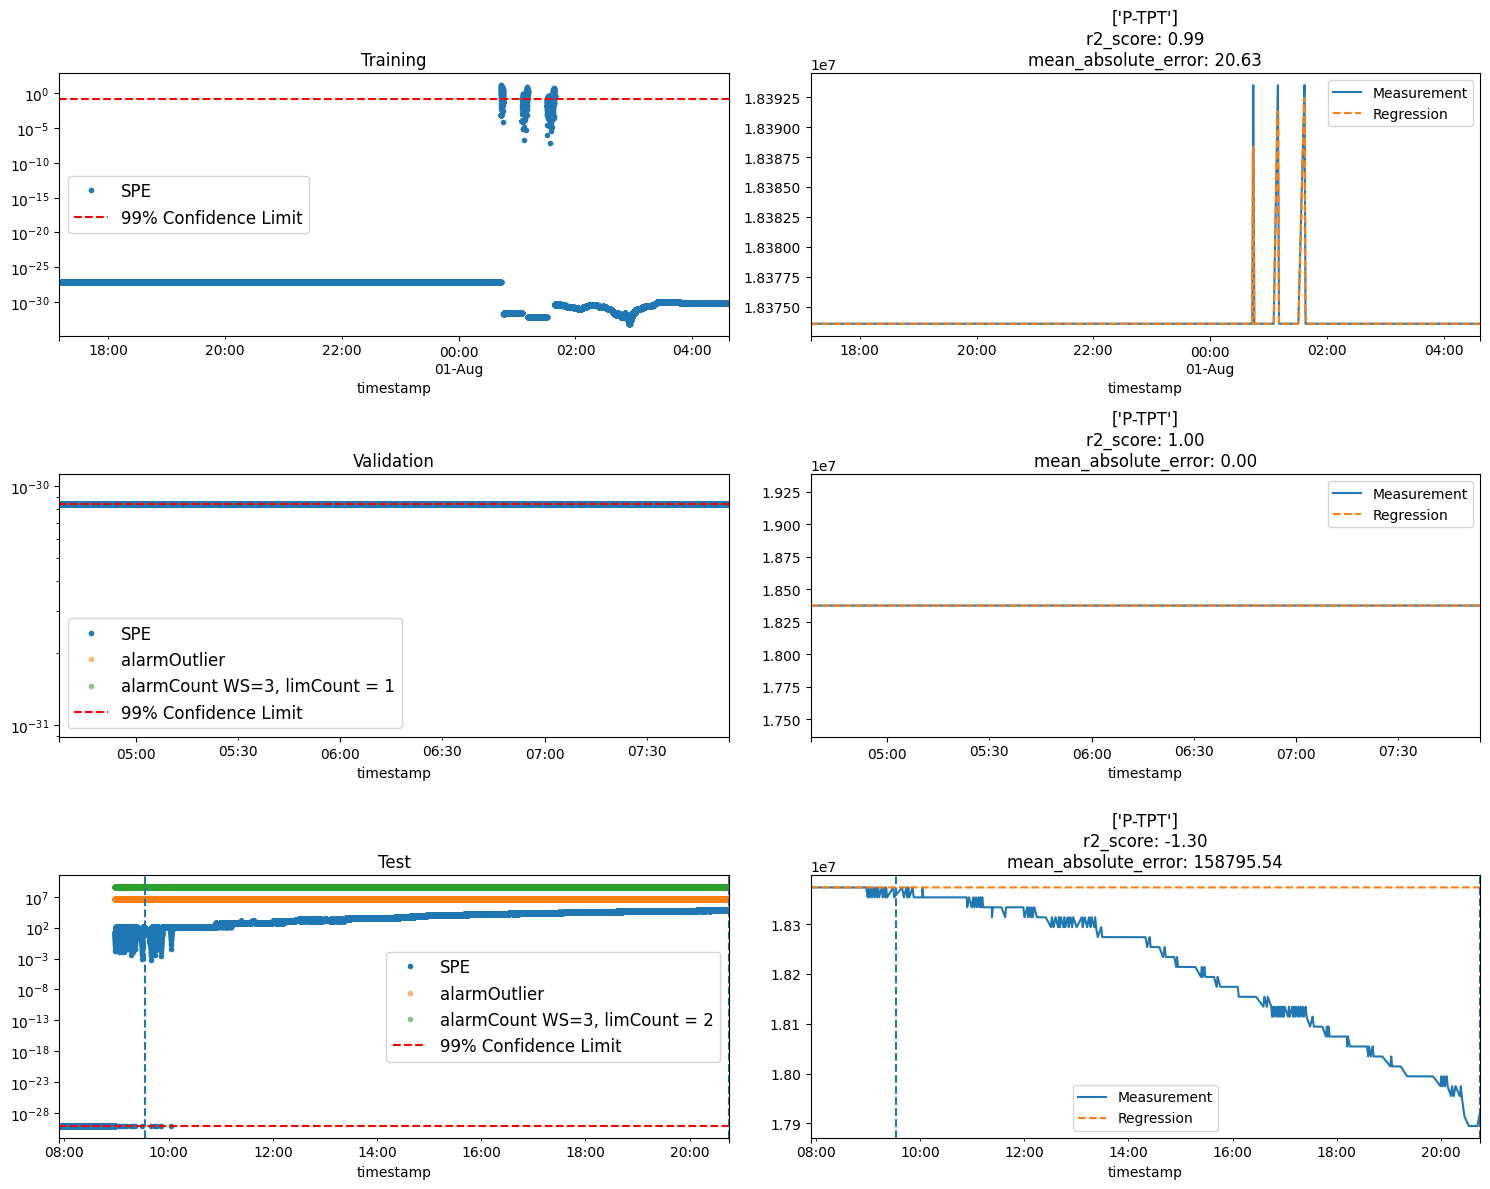

In [13]:
bibmon.complete_analysis(model, X_train['T-JUS-CKP'], X_validation['T-JUS-CKP'], X_test['T-JUS-CKP'], 
                         Y_train, Y_validation, Y_test,                    
                         metrics = mtr, count_window_size = 3, count_limit = 2,
                         fault_start = fault_start,
                         fault_end = fault_end)                       

## Análises e conclusões da segunda tentativa

-  O modelo encontrado continua apresentando alguns alarmes falsos durante a fase de validação e o modelo continua falho pois não modela exatamente o sistemas, como podemos ver nos gráficos de regressão da fase de validação.

Essa análise de verificar a variável mais importante pode ser relevante, mas não nesse momento onde o modelo não está prevendo bem e ainda não sabemos qual conjunto de variáveis utilizar para a previsão

`Propostas futuras para análise dos dados`:
- Encontrar quais variáveis seriam melhores para descrever o modelo e que serão utilizadas no parâmetro tags_Y.
- Ajudar o modelo a encontrar qual variável descreve melhor o sistema para os eventos utilizando as importãncias encontradas na primeira tentativa `após` resolvermos outros problemas como o da tags_Y e da falta de dados para operação normal na base que fornecemos à função de treinamento.
- Analisar todos os arquivos de dados e achar aqueles que são mais promissores para o treinamento com a BibMon, como falamos, nesse aqui o período de validação está muito pequeno, queríamos encontrar diversas operações de falta também, separamos alguns casos que seriam chaves:
    - Caso onde o evento gera longo transitório e depois entra em regime permanente diferente do regime de operação normal.
    - Caso onde o evento tem transitório curto e já entra em regime permanente diferente do regime de operação normal..
    - Caso onde há transitório e o permanente volta ao estado de operação normal, como se fosse uma instabilidade provisória que o próprio sistema consegue controlar de maneira satisfatória
- Concatenar o banco de dados de operação normal com os de falta para ter um período grande para treinamento.

`O que poderíamos já contribuir para BibMon`:
- Criamos funções para leitura de arquivos em parquet e csv que recebem qual evento será escolhido
- Criamos funções modulares para importação dos dados por poço
- Função para plot das variáveis por poço (seria interessante melhorar os plots, permitindo overlap de casos e diversas outras configurações definidas pelo usuário)

## Tentativas com funções de fit e PCA
A seguir iniciaremos o teste de outras funções da BibMon que permitem a validação e treinamento não serem necessariamente consecutivas a falta, o que flexibilizará esse treinamento.


C:\Users\Laura\miniconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


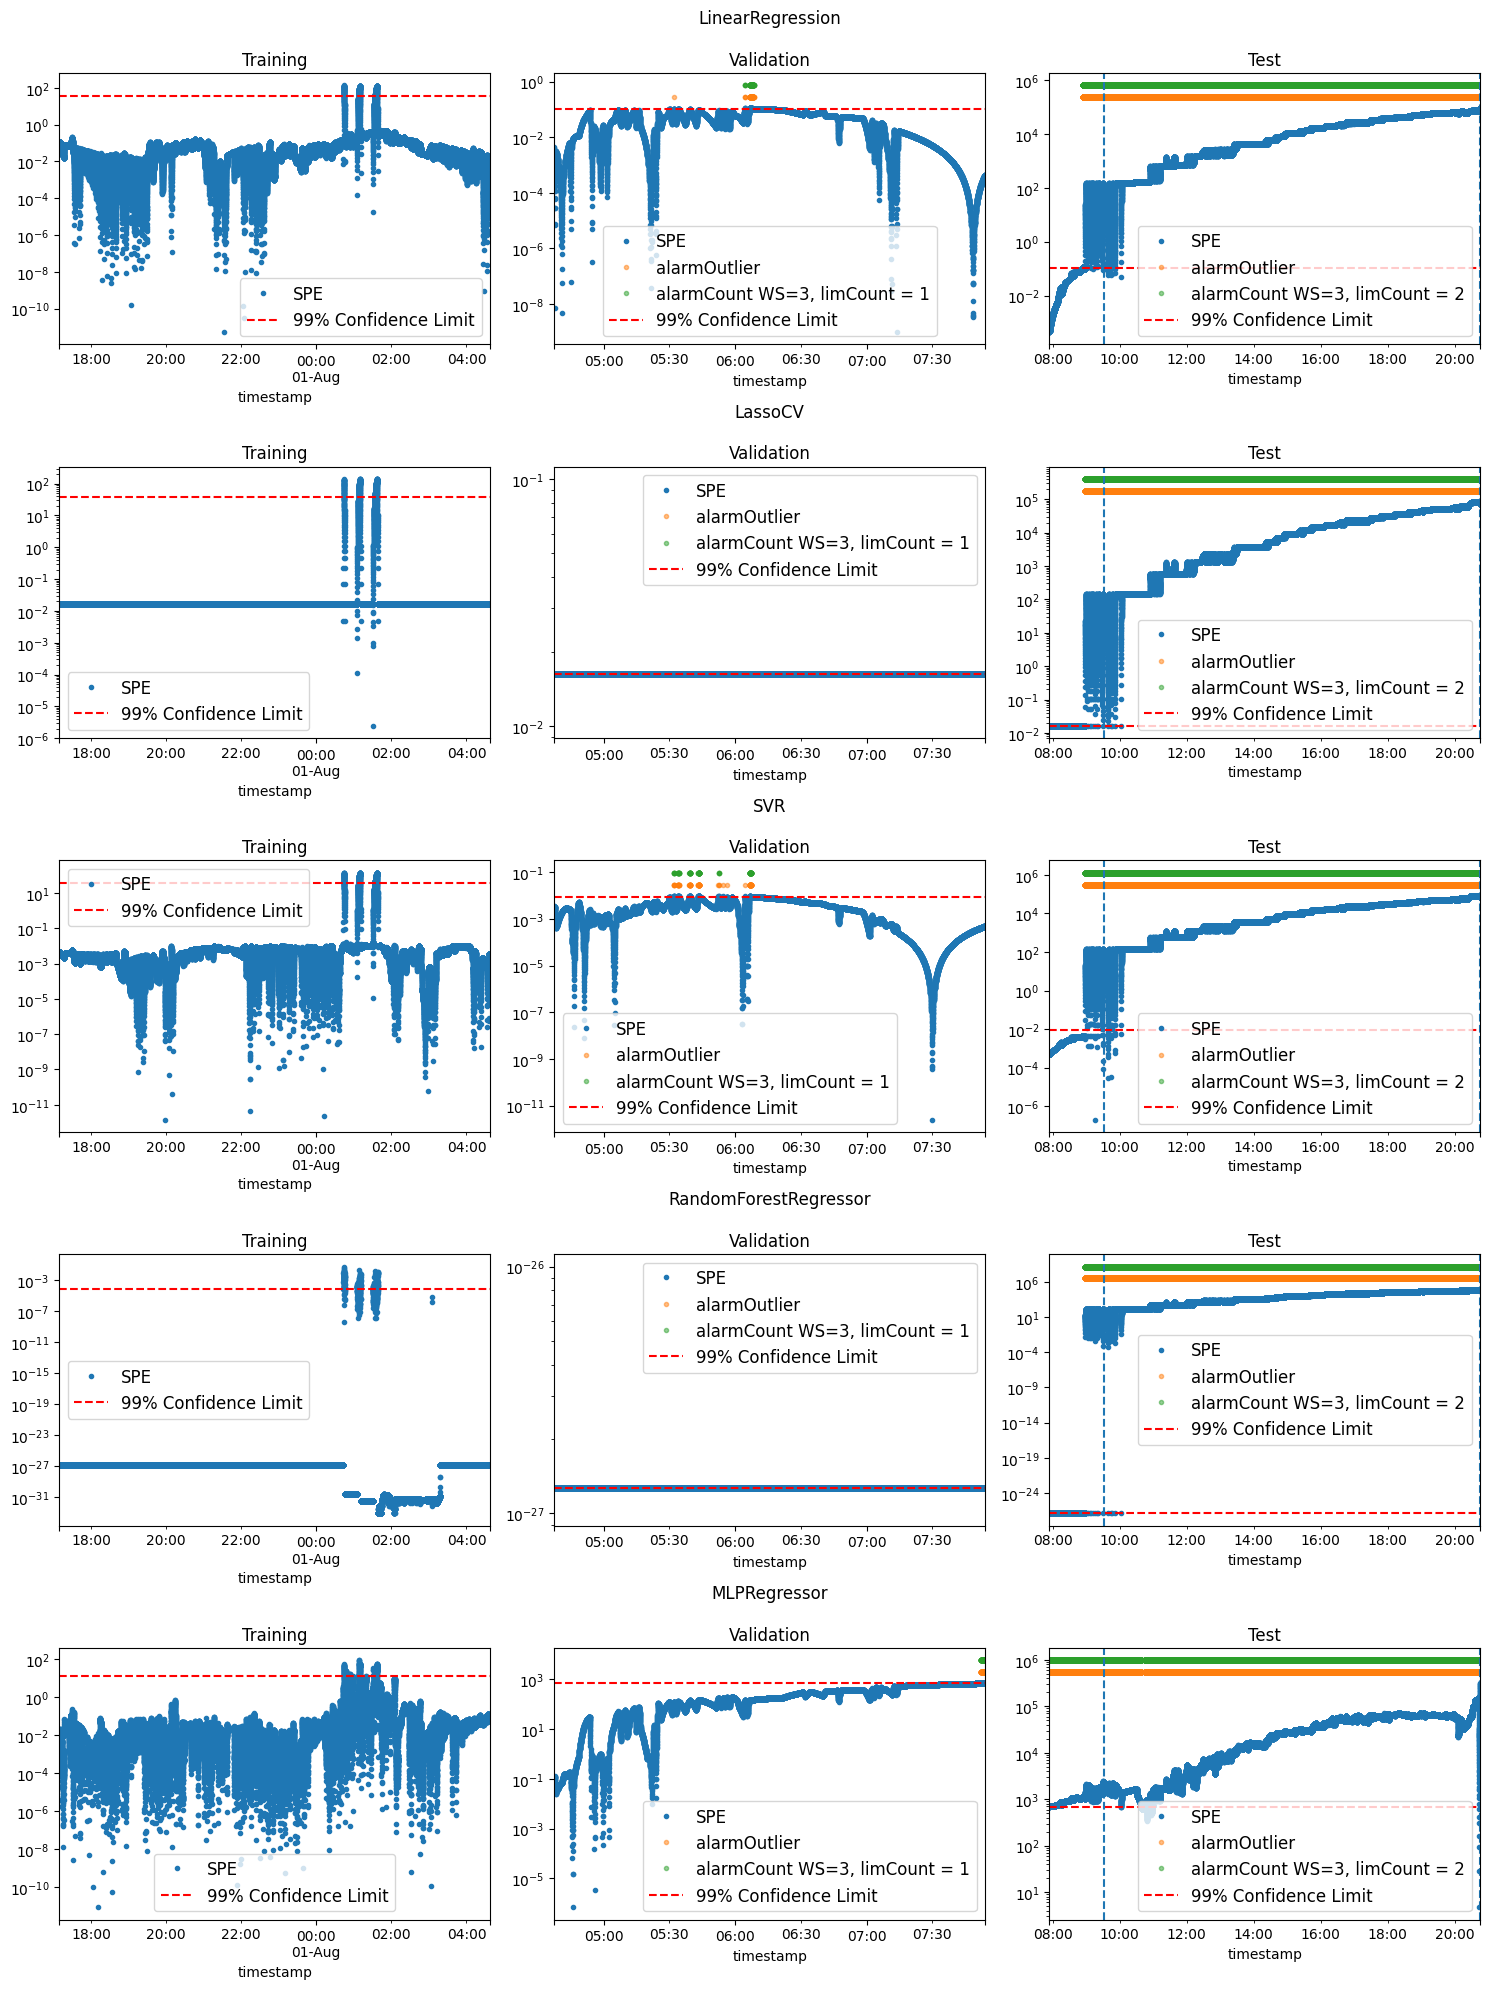

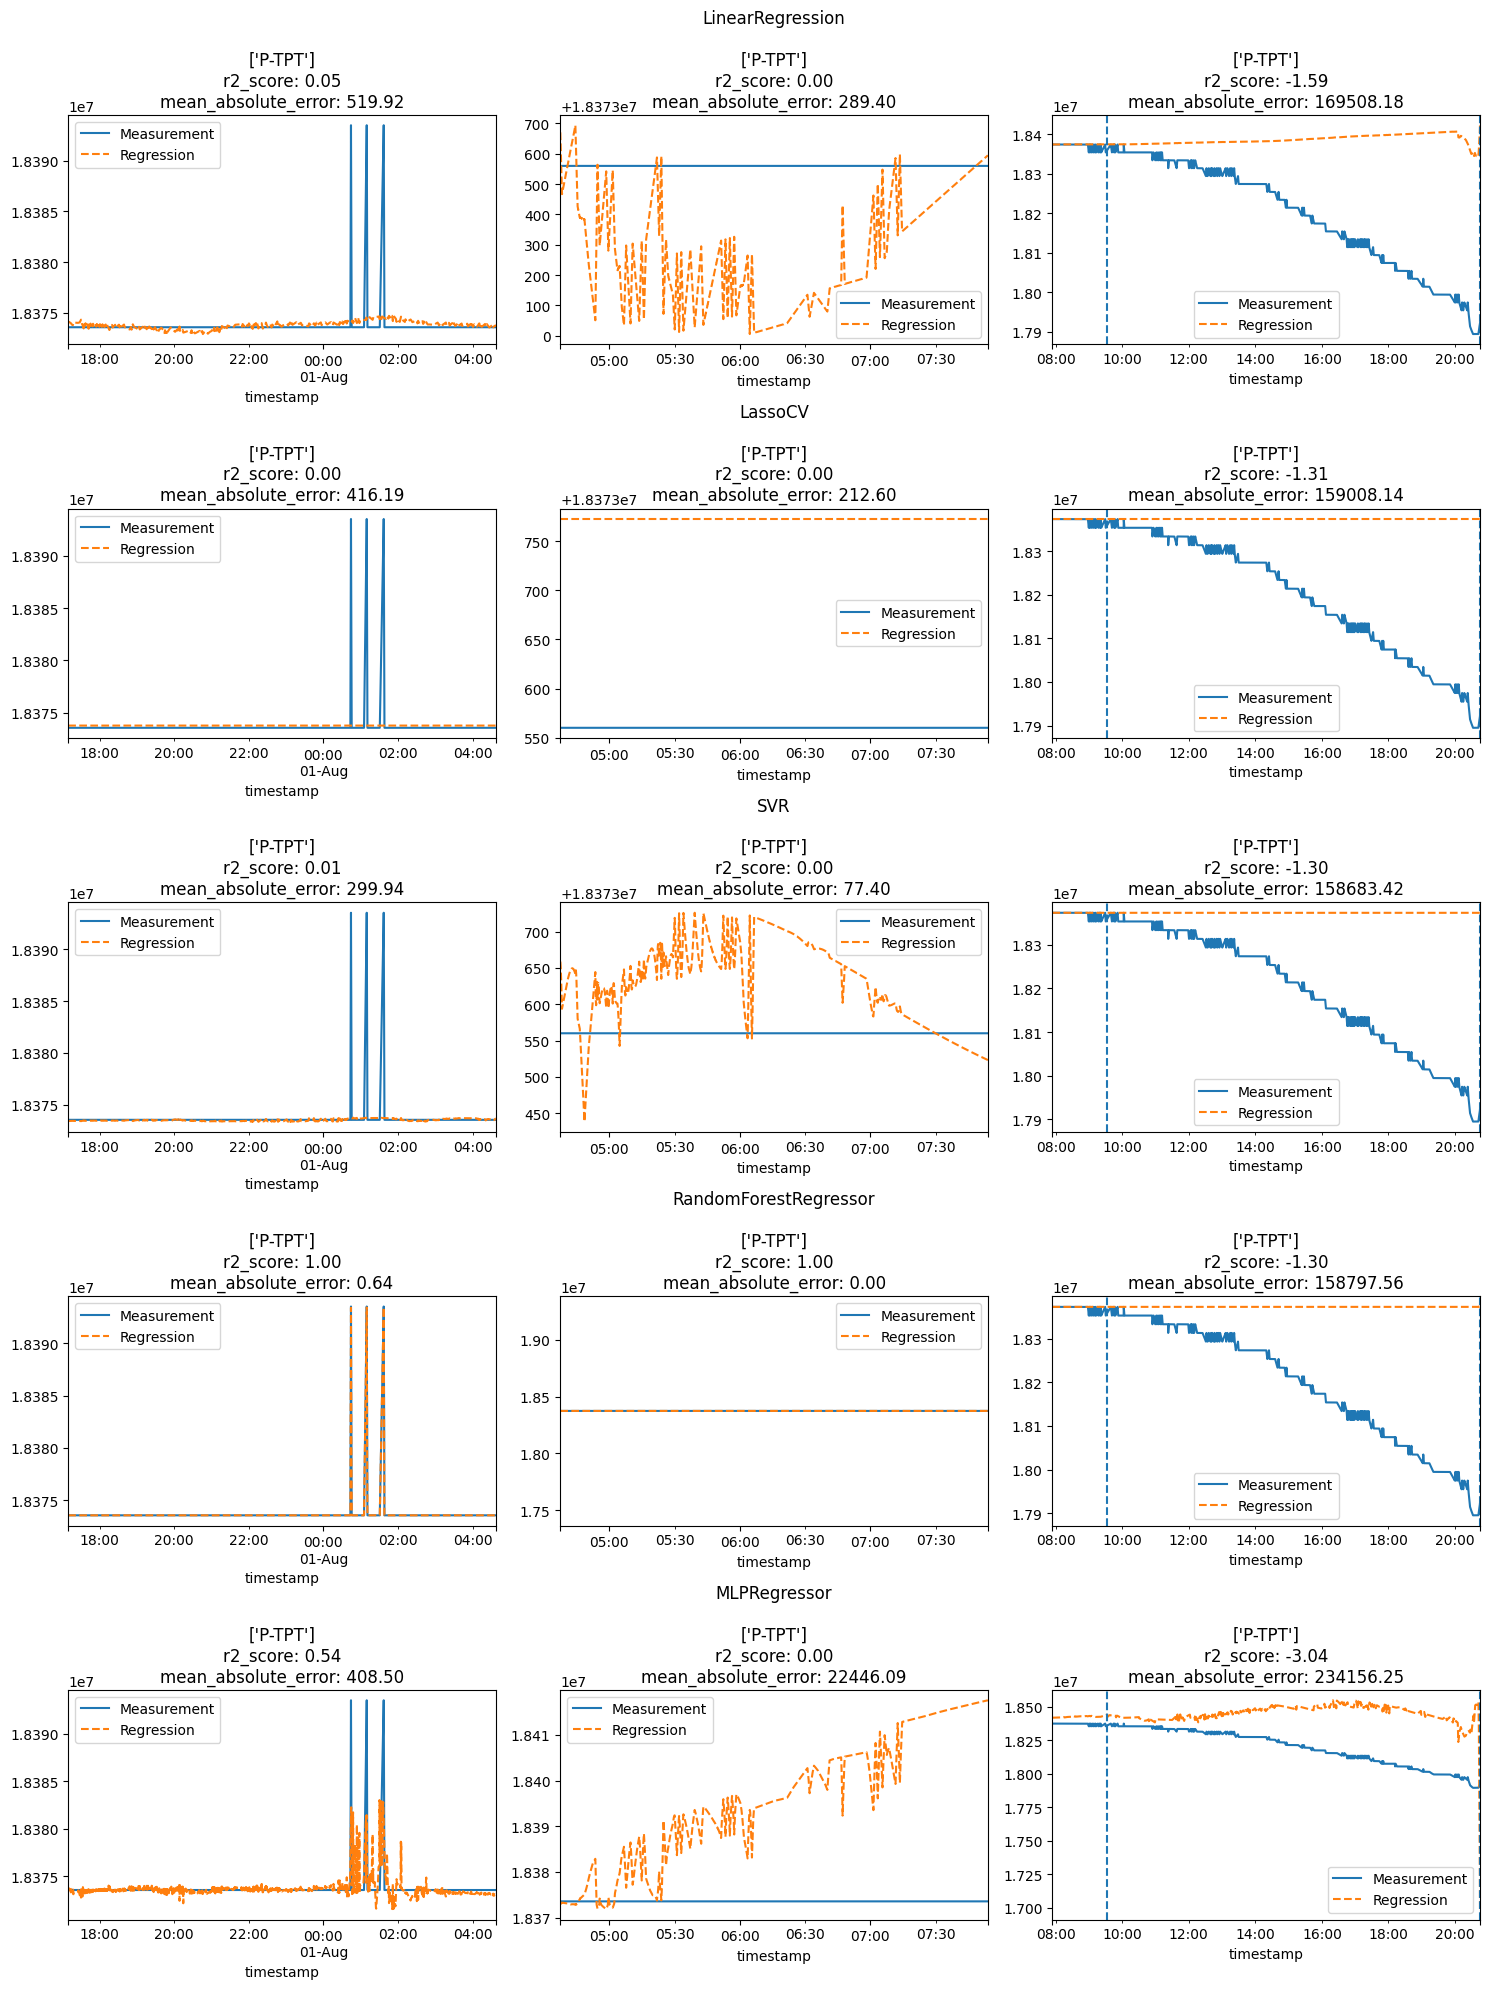

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

sklearn_regs = [LinearRegression(), LassoCV(), SVR(), 
                RandomForestRegressor(n_jobs=-1,random_state=1), 
                MLPRegressor()]

models = [bibmon.sklearnRegressor(reg) for reg in sklearn_regs]

tab_pred, tab_detec, tab_times = bibmon.comparative_table(models, X_train, X_validation, X_test, 
                                                          Y_train, Y_validation, Y_test,                      
                                                          metrics = mtr, count_window_size = 3, count_limit = 2,
                                                          fault_start = fault_start,
                                                          fault_end = fault_end)          